In [1]:
#!/usr/bin/python
import requests # get the requsts library from https://github.com/requests/requests
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
from sklearn.linear_model import LinearRegression

ModuleNotFoundError: No module named 'numpy'

In [ ]:
############################## VARIABLES ##############################
# graf --> los datos de AOD-OMI
# dates --> fechas de AOD-OMI (2015-2018) ***no tiene ciertas fechas
# values --> valores AOD-OMI (2015-2018)
# dosmil15, dosmil16, dosmil17, dosmil18 --> locaciones de values
# ano2015, ano2016, ano2017, ano2018 --> fechas de AOD-OMI
# val2015, val2016, val2017, val2018 --> valores de AOD-OMI
# bb --> tabla del SIMA 2015 cruda 
# NO --> Datos Noroeste 2015 PM10 y PM2.5 promedio diario
# NE --> Datos Noreste 2015 PM10 y PM2.5 promedio diario
# SBE --> Datos Noroeste 2016-2019 PM10 y PM2.5 promedio por hora
# SNI --> Datos Noreste 2016-2019 PM10 y PM2.5 promedio por hora
# NOSBE --> Merge datos PM10 y PM2.5 para Noroeste 2015-2019
# NESNI --> Merge datos PM10 y PM2.5 para Noreste 2015-2019
# frames1, frames 2 --> variable que uso temporalmente para merge, mejor no usarla.
# NOresult --> Datos de Noroeste 2015-2018 AOD, PM10 y PM2.5 promedio diario
# NEresult --> Datos de Noreste 2015-2018 AOD, PM10 y PM2.5 promedio diario
# NEr --> Solo AOD y PM10/2.5 (temp) 
# X --> valores de PM10 o PM2.5 (temp) 2015-2019
# Y --> valores de AOD 2015-2018
# linear_regressor, Y_pred --> Para regresión linear

In [8]:
# overriding requests.Session.rebuild_auth to mantain headers when redirected
 
class SessionWithHeaderRedirection(requests.Session):
 
    AUTH_HOST = 'urs.earthdata.nasa.gov'
 
    def __init__(self, username, password):
 
        super().__init__()
 
        self.auth = (username, password)
 
  
 
   # Overrides from the library to keep headers when redirected to or from
 
   # the NASA auth host.
 
    def rebuild_auth(self, prepared_request, response):
 
        headers = prepared_request.headers
 
        url = prepared_request.url
 
  
 
        if 'Authorization' in headers:
 
            original_parsed = requests.utils.urlparse(response.request.url)
 
            redirect_parsed = requests.utils.urlparse(url)
 
  
 
            if (original_parsed.hostname != redirect_parsed.hostname) and redirect_parsed.hostname != self.AUTH_HOST and original_parsed.hostname != self.AUTH_HOST:
 
                del headers['Authorization']
 
  
 
        return

In [9]:
# create session with the user credentials that will be used to authenticate access to the data
 
username = "constanzazu"
 
password= "T0totlan'"
 
session = SessionWithHeaderRedirection(username, password)
 

In [10]:
# All the urls we want to download
 #borrar primeros dos links
    
#Para solo 2015:
#url_list = open("subset_OMAERUVd_V003_20190830_011347.txt").read().splitlines()
#Para 2015-2018
url_list = open("subset_OMAERUVd_V003_20190901_160425.txt").read().splitlines()
len(url_list)

1443

In [5]:
# loop to extract every file and save it in an ultimate file
m=1
d=1
a=2015
f=28
u=1

#primera columna de DataFrame de promedios
aod = pd.DataFrame(columns=["date","(25.5,-100.5)"])

#loop para descargar todos los datos y hacer un Dataframe de promendios
for url in url_list:
    #filename for the url to be used when saving the file
    filename =  'temp.csv'
    #url[url.rfind('/')+1:]  
    
    try:
        # submit the request using the session
        response = session.get(url, stream=True)
        print(response.status_code)
        # raise an exception in case of http errors
        response.raise_for_status()  
        # save the file
        with open(filename, 'wb') as fd:
            for chunk in response.iter_content(chunk_size=1024*1024):
                fd.write(chunk)
    except requests.exceptions.HTTPError as e:
        # handle any errors here 
        if e!=200:
            print(e,"Problema en {}-{:02d}-{:02d}".format(a,m,d))
        
    #Leer el archivo y acomodar
    datos=pd.read_csv(filename,engine='python',header=None,skiprows=1,skipfooter=2,names=["meh","-101.5", "-100.5", "-99.5", "-98.5"])
    datos.insert(1,"lat/lon",[22.5, 23.5, 24.5, 25.5, 26.5, 27.5],True)
    df=datos.drop('meh', axis=1)
    #para guardar cada dia:
    #export_csv=df.to_csv("./AOD/AOD-{}-{:02d}-{:02d}.csv".format(a,m,d),index=False)
    
    #agregando lineas al DataFrame de promedios
    #df=pd.read_csv("./AOD/AOD-{}-{:02d}-{:02d}.csv".format(a,m,d))
    y=df.at[3,"-100.5"]
    if y<0:
        sum=0
        p=0
        for i in range(2,5):
            for c in range(1,4):
                h=df.iat[i,c]
                if h>0:
                    p=p+1
                    sum=sum+h
        if sum==0:
            y="NaN"
        else:
            y=sum/p
    aod.loc[u] = ["{}-{:02d}-{:02d}".format(a,m,d),y]
    u=u+1
    #para ir cambiando fechas
    if m == 4 or m == 6 or m == 9 or m==11 :
        #se toman en cuenta las exepciones de 2016
        if a==2016 and m==6 and d==10:
            d=14
            #u=u+4
        elif d<30:
            d=d+1
        else:
            m=m+1
            d=1
    elif m == 2:
        if d<f:
            d=d+1
        else:
            m=m+1
            d=1  
    else:
        #se toman en cuenta las exepciones de 2016 y 2017
        if a==2016 and m==5 and d==29:
            m=6
            d=10
            #u=u+12
        elif a==2017 and m==3 and d==12:
            d=17
            #u=u+5
        elif d<31:
            d=d+1
        elif m==12:
            a=a+1
            m=1
            d=1
            #para el año bisiesto:
            if a==2016 or a==2020:
                f=29
            else:
                f=28
        else:
            m=m+1
            d=1
            
#Guardar arshivo de promedios
aod = aod.replace('NaN','')
export_csv=aod.to_csv("./AOD/Promedios.csv",index=False)
#nomás pa que avise:
print("done")

200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200


KeyboardInterrupt: 

In [2]:
#Lee los datos de AOD y los divide por año (para hacer gráficas)
graf=pd.read_csv("./AOD/Promedios.csv",index_col=[0],parse_dates=[0])
#graf.info()
dates=graf.index
values=graf.loc[:,'(25.5,-100.5)']

ano2015 = (graf.index > '2014-12-31') & (graf.index <= '2015-12-31')
dosmil15=graf.loc[ano2015]
ano2016 = (graf.index > '2015-12-31') & (graf.index <= '2016-12-31')
dosmil16=graf.loc[ano2016]
ano2017 = (graf.index > '2016-12-31') & (graf.index <= '2017-12-31')
dosmil17=graf.loc[ano2017]
ano2018 = (graf.index > '2017-12-31') & (graf.index <= '2018-12-31')
dosmil18=graf.loc[ano2018]

ano2015=dosmil15.index
ano2016=dosmil16.index
ano2017=dosmil17.index
ano2018=dosmil18.index
val2015=dosmil15.loc[:,'(25.5,-100.5)']
val2016=dosmil16.loc[:,'(25.5,-100.5)']
val2017=dosmil17.loc[:,'(25.5,-100.5)']
val2018=dosmil18.loc[:,'(25.5,-100.5)']
dosmil15

,"(25.5,-100.5)"
date,
2015-01-01,NaN
2015-01-02,NaN
2015-01-03,NaN
2015-01-04,NaN
2015-01-05,NaN
2015-01-06,NaN
2015-01-07,NaN
2015-01-08,0.246100
2015-01-09,NaN


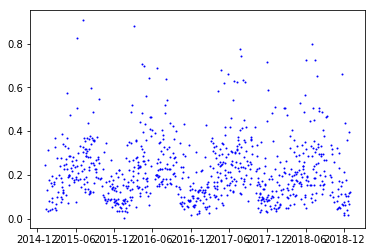

In [3]:
#simple plot
plt.plot(values,"b.",markersize=2)
plt.show()

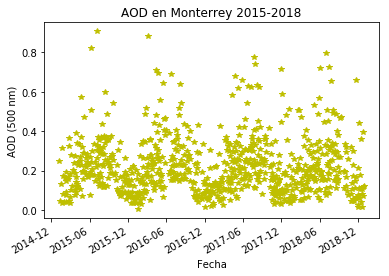

In [4]:
#plot con fechas
plt.plot_date(dates,values,"y*",markersize=6)
plt.gcf().autofmt_xdate()
plt.title('AOD en Monterrey 2015-2018')
plt.xlabel('Fecha')
plt.ylabel('AOD (500 nm)')
#plt.figure(figsize=(100,7))
#plt.legend(loc='best')  # legend text comes from the plot's label parameter.
plt.show()

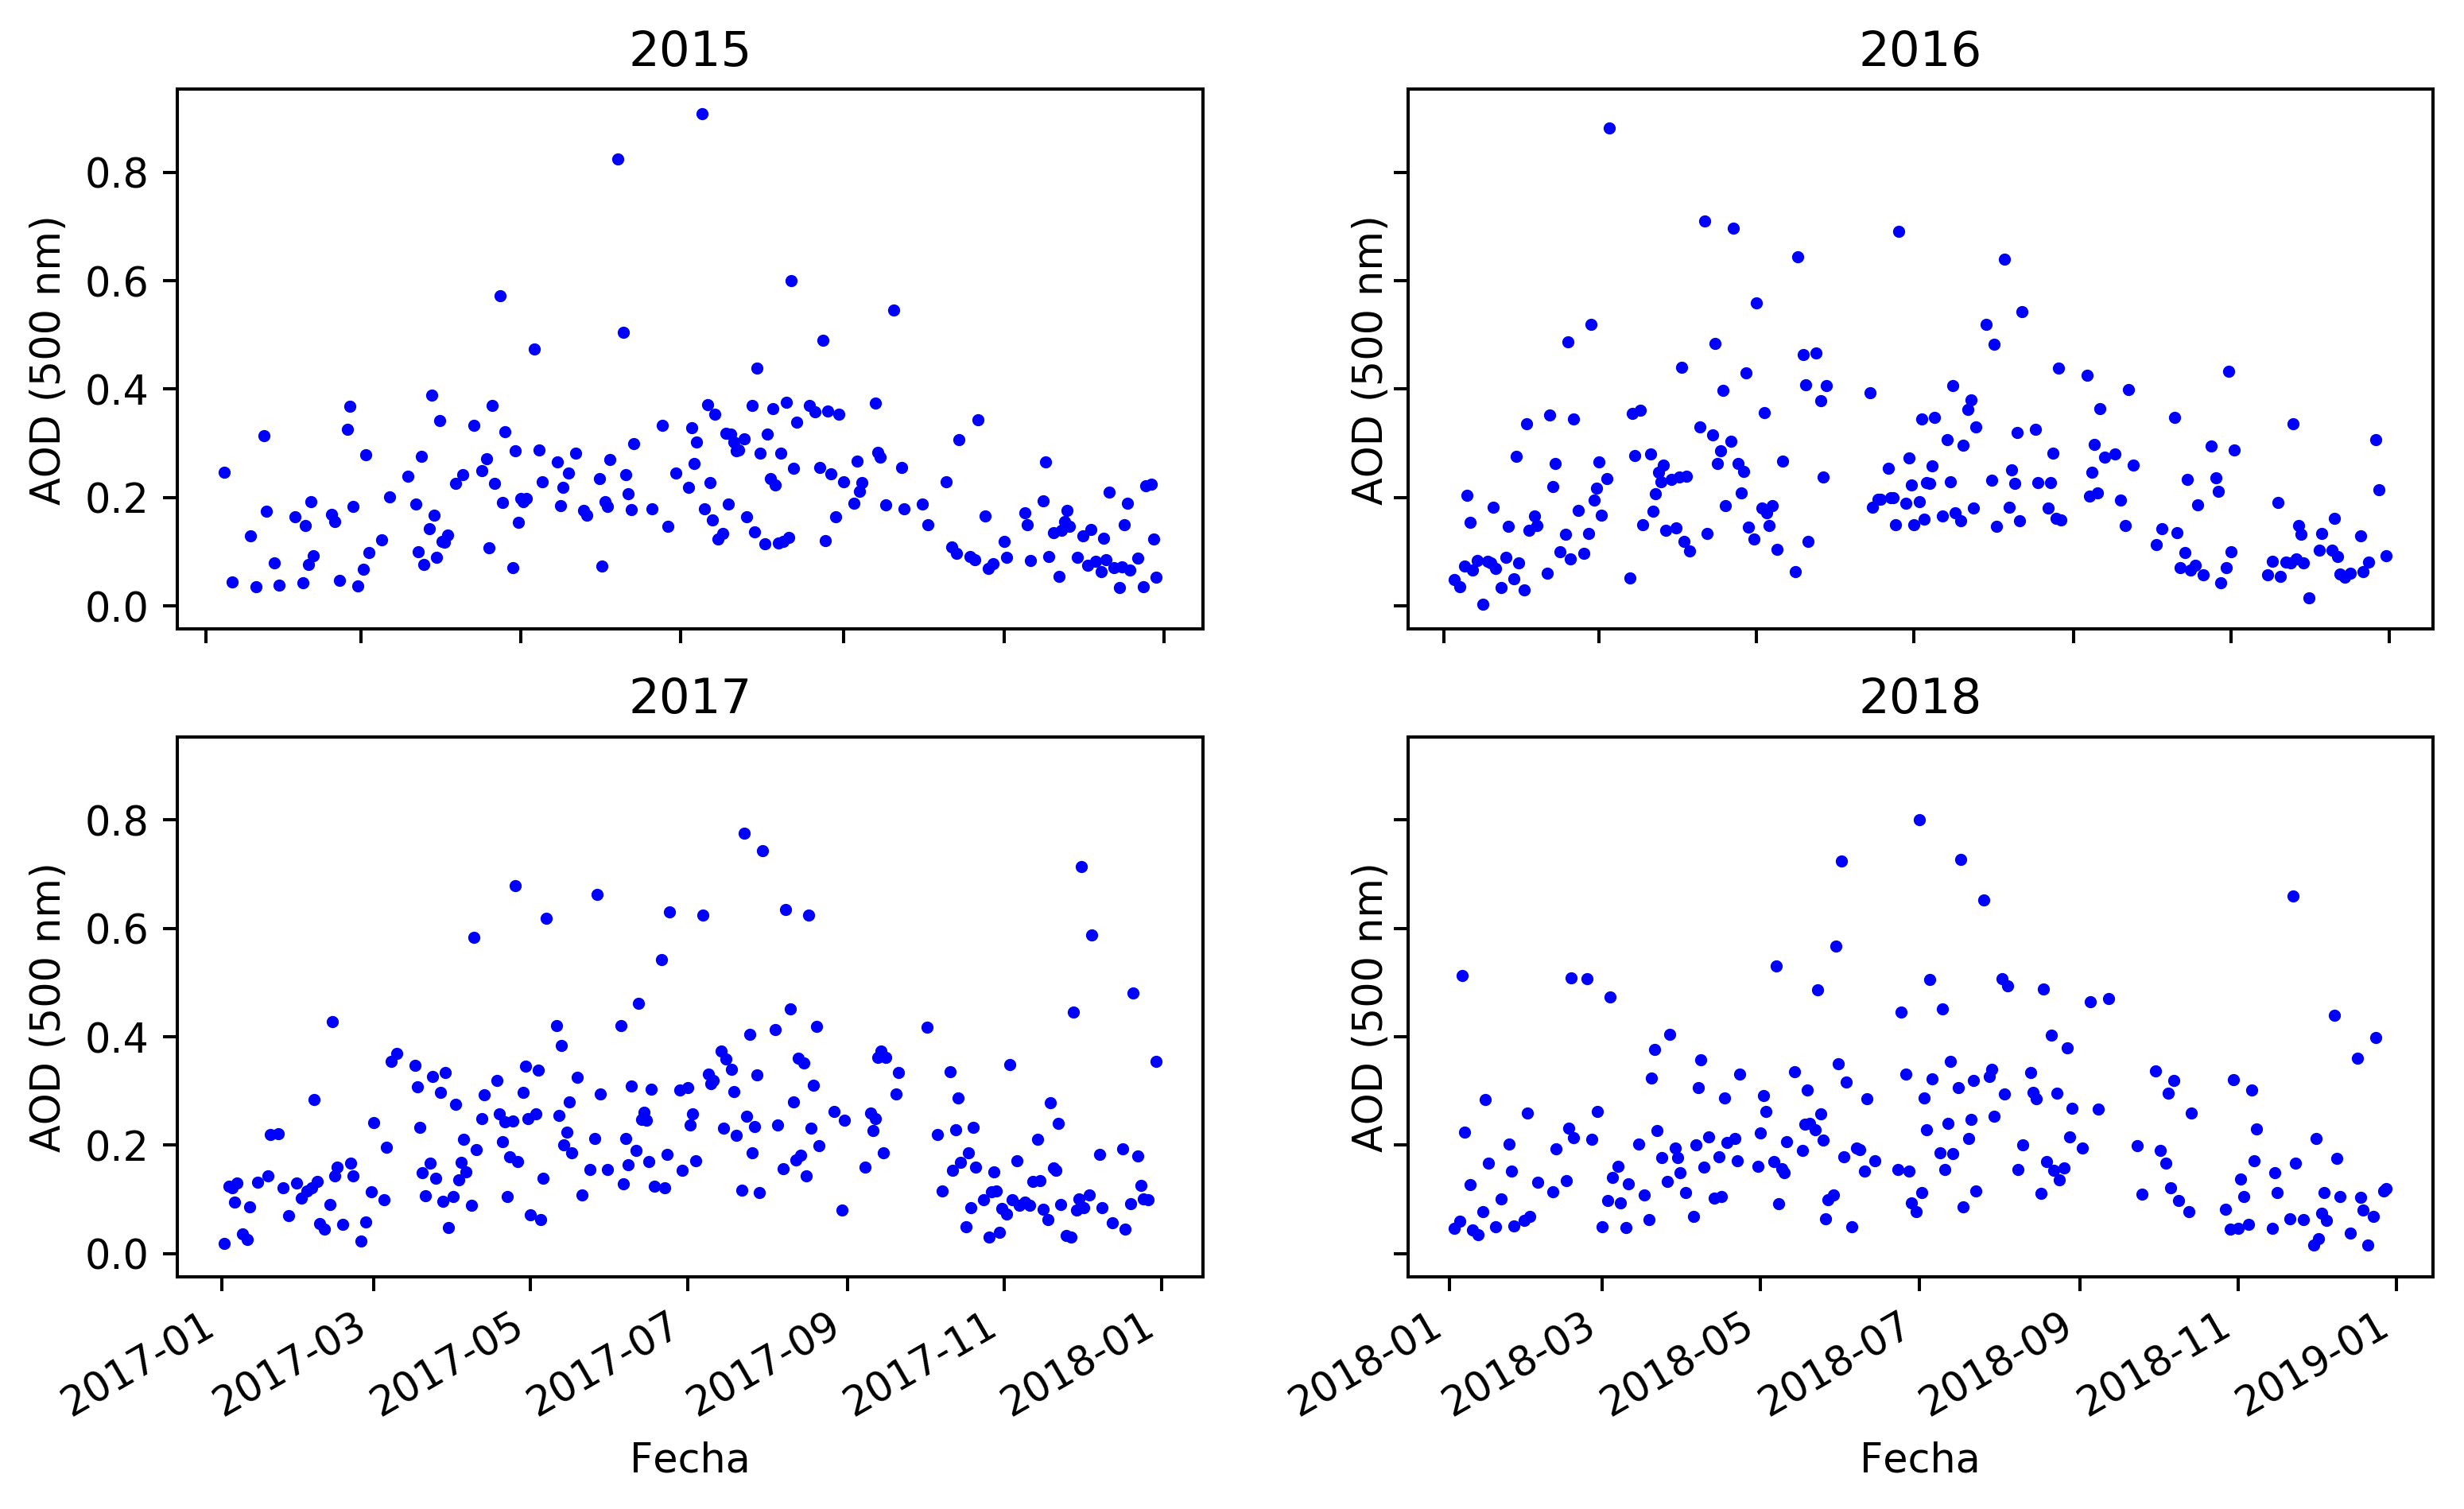

In [5]:
#gráfica por año AOD
fig, ((ax1,ax2),(ax3,ax4))=plt.subplots(2,2,figsize=(10,6),sharex=False,sharey=True,dpi=366)
ax1.plot(ano2015,val2015,"b.",markersize=4)
ax2.plot(ano2016,val2016,"b.",markersize=4)
ax3.plot(ano2017,val2017,"b.",markersize=4)
ax4.plot(ano2018,val2018,"b.",markersize=4)
ax1.set_title('2015'); ax2.set_title('2016'); ax3.set_title('2017'); ax4.set_title('2018')
ax1.set_xlabel('Fecha');  ax2.set_xlabel('Fecha'); ax3.set_xlabel('Fecha');  ax4.set_xlabel('Fecha')
ax1.set_ylabel('AOD (500 nm)');  ax2.set_ylabel('AOD (500 nm)'); ax3.set_ylabel('AOD (500 nm)');  ax4.set_ylabel('AOD (500 nm)')
fig.autofmt_xdate()
#ax1.set_xlim(2015-1-1, 2015-12-31) ;  ax2.set_xlim(2016-1-1, 2016-12-31) 
plt.savefig('AOD-per-year-p.jpg')

In [4]:
#Guardar datos de SIMA por día 

#Leer datos de SIMA (Modificados, +date+time+unit)
bb=pd.read_csv("2015.csv",header=[0,1],index_col=[0] ,parse_dates=[[0,1]],keep_default_na=False)
bb=bb.drop('unit ', axis=0) #no nos importa las unidades aqui
#list(bb.index) 

#Guarda solo los datos de la estacion NOROESTE
NO=bb['NOROESTE']
NO=NO[['PM10','PM2.5']]
#print(NO.columns.tolist())

#Poner los datos en el formato indicado
NO.index=pd.to_datetime(NO.index,dayfirst=True)
NO['PM10']=pd.to_numeric(NO['PM10'])
NO['PM2.5']=pd.to_numeric(NO['PM2.5'])
#NO.dtypes

#Promedios diarios
#NO=NO.resample("D").mean()

#Guardar archivo de promedios
NO = NO.replace(np.nan,'')
export_csv=NO.to_csv("NOPromedio.csv")
#NO

#Guarda solo los datos de la estacion NORESTE
NE=bb['NORESTE']
NE=NE[['PM10','PM2.5']]
#print(NE.columns.tolist())

#Poner los datos en el formato indicado
NE.index=pd.to_datetime(NE.index,dayfirst=True)
NE['PM10']=pd.to_numeric(NE['PM10'])
NE['PM2.5']=pd.to_numeric(NE['PM2.5'])
#NE.dtypes

#Promedios diarios
#NE=NE.resample("D").mean()

#Guardar archivo de promedios
NE = NE.replace(np.nan,'')
export_csv=NE.to_csv("NEPromedio.csv")
NE


C:\Users\Constanza\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (2,10,16,26,29,30,42,45,48,89,90,91,93,94,130,131,132,133,137,138,139,141,142,146,148,149,154,155,158,160) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


date,PM10,PM2.5
2015-01-01 00:00:00,60,
2015-01-01 01:00:00,139,80
2015-01-01 02:00:00,42,29
2015-01-01 03:00:00,23,9
2015-01-01 04:00:00,21,
2015-01-01 05:00:00,23,14
2015-01-01 06:00:00,13,
2015-01-01 07:00:00,13,
2015-01-01 08:00:00,15,8
2015-01-01 09:00:00,16,6


In [21]:
#Nuevos datos

#Para NO
#quitarle acentos al nombre para que pueda leerlo
SBE=pd.read_csv("SAN_BERNABE_ENE2016_AGO2019.csv",header=[0],index_col=[0])
#list(bb.index) 
SBE=SBE[['PM10','PM2.5']]
#print(NO.columns.tolist())

#Poner los datos en el formato indicado
SBE.index=pd.to_datetime(SBE.index,dayfirst=True)
SBE['PM10']=pd.to_numeric(SBE['PM10'])
SBE['PM2.5']=pd.to_numeric(SBE['PM2.5'])

#SBE.dtypes

#Promedios diarios
#SBE=SBE.resample("D").mean()

#Guardar archivo de promedios
SBE = SBE.replace(np.nan,'')
SBE = SBE.sort_index()
export_csv=SBE.to_csv("SBEPromedio_diario.csv")
#SBE

#Para NE
#Quitar acentos a los nombres
SNI=pd.read_csv("SAN_NICOLAS_ENE2016_AGO2019.csv",header=[0],index_col=[0])
#list(bb.index) 
SNI=SNI[['PM10','PM2.5']]
#print(NE.columns.tolist())

#Poner los datos en el formato indicado
SNI.index=pd.to_datetime(SNI.index,dayfirst=True)
SNI['PM10']=pd.to_numeric(SNI['PM10'])
SNI['PM2.5']=pd.to_numeric(SNI['PM2.5'])
#SNI.dtypes

#Promedios diarios
#SNI=SNI.resample("D").mean()

#Guardar archivo de promedios
SNI = SNI.replace(np.nan,'')
SNI = SNI.sort_index()
export_csv=SNI.to_csv("SNIPromedio_diario.csv")
SNI

,PM10,PM2.5
date,,
2016-01-01 00:00:00,109,
2016-01-01 01:00:00,233,161
2016-01-01 02:00:00,82,
2016-01-01 03:00:00,35,
2016-01-01 04:00:00,33,
2016-01-01 05:00:00,26,
2016-01-01 06:00:00,21,
2016-01-01 07:00:00,18,7
2016-01-01 08:00:00,25,


In [29]:
#AQUI TENGO QUE SELECCIONAR SOLO LAS HORAS QUE PASA EL SATÉLITE Y PROMEDIARLO PARA LOS PMS, y que solo diga fechas
#Mergear NO y SBE
frames1=[NO,SBE] #Noroeste = San Bernabe
NOSBE=pd.concat(frames1,axis=0)
#Mergear NE y SNI
frames1=[NE,SNI] #Noreste = San Nicolas
NESNI=pd.concat(frames1,axis=0)
#Solo toma en cuenta 13:00:00 y luego se borra la hora del índice
unapm=[ind for ind in NOSBE.index if (ind.hour==13)]
NOSBE=NOSBE.loc[unapm]
NOSBE=NOSBE.resample("D").sum()
NESNI=NESNI.loc[unapm]
NESNI=NESNI.resample("D").sum()
NOSBE

date,PM10,PM2.5
2015-01-01,38,34
2015-01-02,83,47
2015-01-03,79,37
2015-01-04,25,
2015-01-05,109,28
2015-01-06,134,60
2015-01-07,71,35
2015-01-08,66,20
2015-01-09,76,32
2015-01-10,42,29


In [45]:
#JUNTAR LAS TABLAS AOD-PM10-PM2.5 2015-2019

#graf.set_index("date",inplace=True) #Para que la grafica de AOD tenga el mismo index que las demas (a veces se tiene que correr y a veces no)
#print(graf.columns.tolist())

#NOROESTE
frames2=[graf,NOSBE]
NOresult=pd.concat(frames2,axis=1)
NOresult = NOresult.replace(np.nan,'')
export_csv=NOresult.to_csv("NO-AOD-PMs-2015-2019.csv")
NOresult.index=pd.to_datetime(NOresult.index)
NOresult['PM10']=pd.to_numeric(NOresult['PM10'])
NOresult['PM2.5']=pd.to_numeric(NOresult['PM2.5'])

#NORESTE
frames2=[graf,NESNI]
NEresult=pd.concat(frames2,axis=1)
NEresult = NEresult.replace(np.nan,'')
export_csv=NEresult.to_csv("NE-AOD-PMs-2015-2019.csv")
NEresult.index=pd.to_datetime(NEresult.index)
NEresult = NEresult.replace(np.nan,'')
NEresult['PM10']=pd.to_numeric(NEresult['PM10'])
NEresult['PM2.5']=pd.to_numeric(NEresult['PM2.5'])
NEresult['(25.5,-100.5)']=pd.to_numeric(NEresult['(25.5,-100.5)'])
NEresult
#NOresult

,"(25.5,-100.5)",PM10,PM2.5
2015-01-01,NaN,32.0,16.00
2015-01-02,NaN,49.0,14.00
2015-01-03,NaN,44.0,30.00
2015-01-04,NaN,40.0,5.00
2015-01-05,NaN,73.0,22.00
2015-01-06,NaN,116.0,22.00
2015-01-07,NaN,NaN,25.00
2015-01-08,0.2461,57.0,8.00
2015-01-09,NaN,44.0,7.00
2015-01-10,NaN,15.0,NaN


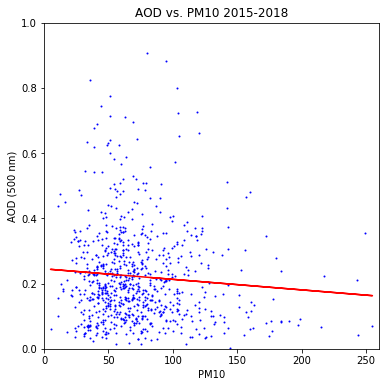

0.006566768046272431


In [35]:
NEr=NEresult.loc[:,["(25.5,-100.5)","PM10"]]
NEr=NEr.dropna(axis=0) #Se quitan lineas sin valores ya sea de AOD o PM
X=NEr["PM10"].values.reshape(-1, 1)
Y=NEr["(25.5,-100.5)"].values.reshape(-1, 1)
linear_regressor = LinearRegression()
linear_regressor.fit(X, Y)
Y_pred = linear_regressor.predict(X)
fig= plt.figure(figsize=(6,6))
plt.plot(X,Y,"b.",markersize=2)
plt.plot(X, Y_pred, color='red')
plt.axis([0, 260, 0, 1])
plt.title('AOD vs. PM10 2015-2018')
plt.ylabel('AOD (500 nm)')
plt.xlabel('PM10')
#plt.savefig('NE-AOD-PM10.jpg')
plt.show()
print(linear_regressor.score(X,Y))

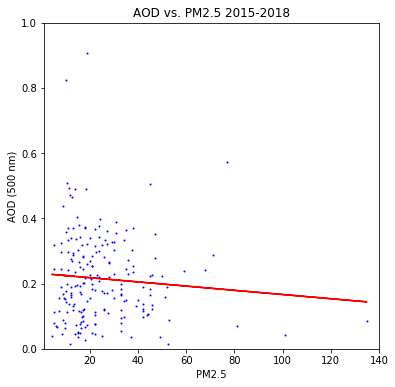

0.0066604225073649825


In [38]:
NEr=NEresult.loc[:,["(25.5,-100.5)","PM2.5"]]
NEr=NEr.dropna(axis=0)
X=NEr["PM2.5"].values.reshape(-1, 1)
Y=NEr["(25.5,-100.5)"].values.reshape(-1, 1)
linear_regressor = LinearRegression()
linear_regressor.fit(X, Y)
Y_pred = linear_regressor.predict(X)
fig= plt.figure(figsize=(6,6))
plt.plot(X,Y,"b.",markersize=2)
plt.plot(X, Y_pred, color='red')
plt.axis([1, 140, 0, 1])
plt.title('AOD vs. PM2.5 2015-2018')
plt.ylabel('AOD (500 nm)')
plt.xlabel('PM2.5')
#plt.savefig('NE-AOD-PM2-5.jpg')
plt.show()
print(linear_regressor.score(X,Y))

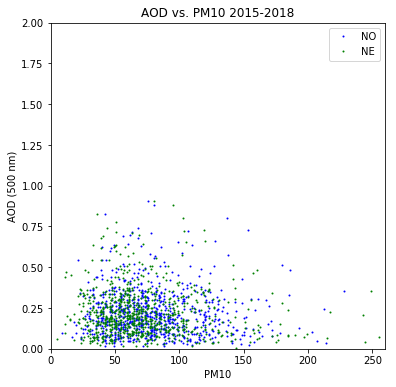

In [41]:
NOresult = NOresult.replace('',np.nan)
NEresult = NEresult.replace('',np.nan)
fig= plt.figure(figsize=(6,6))
plt.plot(NOresult["PM10"],NOresult["(25.5,-100.5)"],"b.",markersize=2,label="NO")
plt.plot(NEresult["PM10"],NEresult["(25.5,-100.5)"],"g.",markersize=2,label="NE")
plt.axis([0, 260, 0, 2])
plt.legend(loc='best')
plt.title('AOD vs. PM10 2015-2018')
plt.ylabel('AOD (500 nm)')
plt.xlabel('PM10')
#plt.savefig('AOD-PM10.jpg')
plt.show()

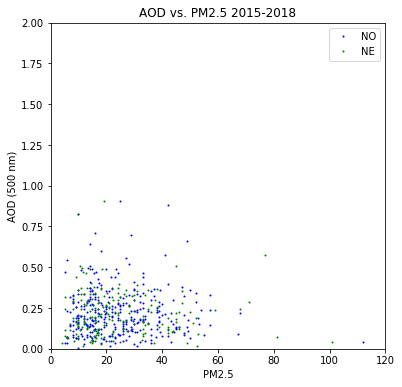

In [42]:
fig= plt.figure(figsize=(6,6))
plt.plot(NOresult["PM2.5"],NOresult["(25.5,-100.5)"],"b.",markersize=2,label="NO")
plt.plot(NEresult["PM2.5"],NEresult["(25.5,-100.5)"],"g.",markersize=2,label="NE")
plt.axis([0, 120, 0, 2])
plt.legend(loc='best')
plt.title('AOD vs. PM2.5 2015-2018')
plt.ylabel('AOD (500 nm)')
plt.xlabel('PM2.5')
#plt.savefig('AOD-PM2-5.jpg')
plt.show()

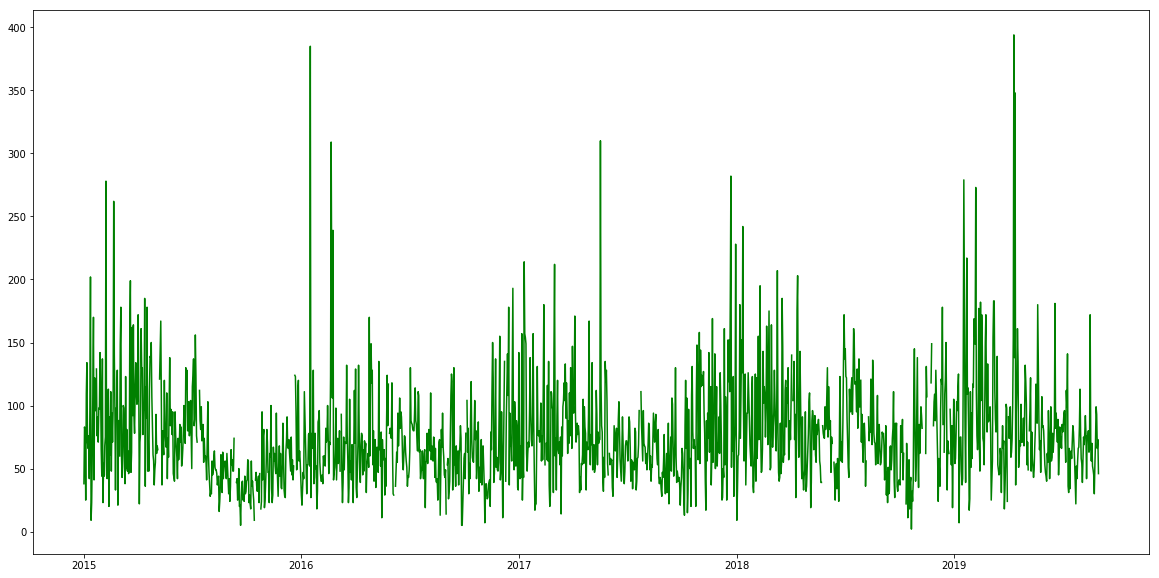

In [44]:
#COMPORTAMIENTO DIARIO DE PM10
merge = NOSBE.replace('',np.nan)
fig= plt.figure(figsize=(20,10))
plt.plot_date(merge.index,merge["PM10"],"g-",markersize=6)
#plt.plot_date(merge.index,merge["PM2.5"],"y*",markersize=6)
#plt.axis([2015, 2017, 0, 230])
#merge.index
#COMO HACER QUE EN ESTE MISMO DATAFRAME SE GRAFIQUE CADA AÑO EN UN MISMO PLOT